# Sprint10 ディープニューラルネットワーク

## 【問題1】全結合層のクラス化
---
全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、すべて全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [49]:
import numpy as np

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = initializer

        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)

        # 微分した重みとバイアス
        self.dW = None
        self.dB = None

        self.x = None

        # AdaGrad用のインスタンス変数
        self.W_h = 0
        self.B_h = 0

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """

        self.x = X  # backwardで使うため保持
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        dZ = np.dot(dA, self.W.T)
        self.dW = np.dot(self.x.T, dA)
        self.dB = np.sum(dA, axis=0)

        # 更新
        self = self.optimizer.update(self)

        return dZ



## 【問題2】初期化方法のクラス化
---
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [50]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = self.sigma * np.random.randn(n_nodes2)
        return b


## 【問題3】最適化手法のクラス化
---
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [51]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """

        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

        return layer


## 【【問題4】活性化関数のクラス化
---
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [52]:
def cross_entropy_error(y, Z3):
    '''
    交差エントロピー誤差の計算
    '''

    DELTA = 1e-7
    batch_size = y.shape[0]
    return -np.sum(y * np.log(Z3 + DELTA))/batch_size


class Softmax:
    """
    ソフトマックス関数
    Parameters
    ----------

    """
    def __init__(self):
        self.loss = None

    def forward(self, X):

        X = X.T
        y = np.exp(X) / np.sum(np.exp(X), axis=0)

        return y.T

    def backward(self, Z3, y):
        batch_size = y.shape[0]
        ret = (Z3 - y)/batch_size

        # lossの計算
        self.loss = cross_entropy_error(y, Z3)

        return ret


## 【問題5】ReLUクラスの作成
---
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。  

$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$

x: ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

一方、バックプロパゲーションのための x に関する$f(x)$の微分は以下のようになります。

$
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$

数学的には微分可能ではないですが、$x=0$ のとき 0とすることで対応しています。

フォワード時の xの正負により、勾配を逆伝播するかどうかが決まるということになります。

In [53]:
class ReLU:
    """
    ReLU関数
    Parameters
    ----------
    """
    def __init__(self):
        self.x = None

    def forward(self, X):

        self.x = X

        return np.maximum(0, X)

    def backward(self, X):

        return np.where(self.x > 0, X, 0)



## 【問題6】重みの初期値
---
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

### Xavierの初期値
---
Xavierの初期値における標準偏差$σ$は次の式で求められます。

$
\sigma = \frac{1}{\sqrt{n}}
$

n: 前の層のノード数


### Heの初期値
---
Heの初期値における標準偏差 σ

は次の式で求められます。

$
\sigma = \sqrt{\frac{2}{n}}
$

n: 前の層のノード数

In [54]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    """
    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        sigma = 1.0 / np.sqrt(n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = np.random.randn(n_nodes2)
        return b

class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    """
    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        sigma = np.sqrt( 2.0 / n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = np.random.randn(n_nodes2)
        return b



## 【問題7】最適化手法
---
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

まず、これまで使ってきたSGDを確認します。

$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$

α : 学習率（層ごとに変えることも可能だが、基本的にはすべて同じとする）

$\frac{\partial L}{\partial W_i}: Wi に関する損失$L$の勾配

$\frac{\partial L}{\partial B_i}$:$B_i$ に関する損失$L$の勾配

E(): ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 H

を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$

$H_i$: i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H′_i$: 更新した$H_i$



In [55]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        DELTA = 1e-7
        layer.W_h += layer.dW * layer.dW
        layer.W -= self.lr * (1.0 / np.sqrt(layer.W_h + DELTA)) * layer.dW / layer.x.shape[0]

        layer.B_h += layer.dB * layer.dB
        layer.B -= self.lr * (1.0 / np.sqrt(layer.B_h + DELTA)) * layer.dB / layer.x.shape[0]

        return layer

## 【問題8】クラスの完成
---

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [56]:
class Tanh:
    """
    ハイボリックタンジェント関数
    Parameters
    ----------
    """
    def __init__(self):
        self.dA = None

    def forward(self, X):

        self.dA = np.tanh(X)
        return self.dA

    def backward(self, dZ):

        return dZ*(1 - np.tanh(self.dA)**2)

In [57]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, batch_size, n_features, n_nodes1, n_nodes2, n_output, lr, sigma=0.01, optimizer=SGD, activation=Tanh, itializer=SimpleInitializer):
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1    # 1層目のノード数
        self.n_nodes2 = n_nodes2    # 2層目のノード数
        self.n_output = n_output    # 出力層のノード数
        self.lr = lr        # 学習率
        self.sigma = sigma  # ガウス分布の標準偏差

        # self.optimizer = optimizer(self.lr)
        self.itializer = itializer
        self.optimizer = optimizer
        self.activation = activation
        self.FC1 = FC(self.n_features, self.n_nodes1, self.itializer(self.sigma), self.optimizer(self.lr))
        self.activation1 = self.activation()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.itializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activation()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.itializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()

        self.loss_list = []

    def fit(self, X, y, X_val=None, y_val=None):

        Z3 = self._forward(X)
        self._backward(X, y, Z3)

        # 損失関数の値を保持
        self.loss_list.append(self.activation3.loss)


    def _forward(self, X):

        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        return Z3


    def _backward(self, X, y, Z3):

        dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
            特徴量ベクトル
        Returns
        -------
        y_pred：次の形のndarray, shape (batch_size, n_output)
            推定結果（10個の確率の中で、最も高いインデックス＝各ラベル（0〜9））
        """
        y_pred = self._forward(X)

        return y_pred.argmax(axis=1)


In [58]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題9】学習と推定
---
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

### データの準備
---

In [59]:
# データの準備
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# One-hotエンコーダー
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

# print(y_train_one_hot.shape)
# print(y_val_one_hot.shape)

# get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)

# get_mini_batch = get_mini_batch_data()
# print(len(get_mini_batch)) # 2400

# m_x, m_y = get_mini_batch[5]
# print(m_x.shape, m_y.shape)



### 学習と推定
---

In [60]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
lr = 0.05 # 学習率
epoch = 5 #エポック回数

# optimizer=SGD, activation=Tanh, itializer=SimpleInitializer
DNN = ScratchDeepNeuralNetrowkClassifier(batch_size, n_features, n_nodes1, n_nodes2, n_output, lr)

# optimizer = AdaGrad
# activation = ReLU
# itializer = HeInitializer

DNN2 = ScratchDeepNeuralNetrowkClassifier(batch_size, n_features, n_nodes1, n_nodes2, n_output, lr, optimizer=AdaGrad, activation=ReLU, itializer=HeInitializer)

for p in range(epoch):

    get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20, seed=p)

    # 2400回分ミニバッチを実行する
    for i in range(len(get_mini_batch)):

        mini_X_train, mini_y_train = get_mini_batch[i]
        # mini_X_val, mini_y_val = val_get_mini_batch[i]

        DNN.fit(mini_X_train, mini_y_train)
        DNN2.fit(mini_X_train, mini_y_train)


        
    y_pred = DNN.predict(X_val)
    y_val_argmax = y_val_one_hot.argmax(axis=1)
    accuracy = np.sum(y_pred == y_val_argmax) / float(X_val.shape[0])
    
    y_pred2 = DNN2.predict(X_val)
    y_val_argmax = y_val_one_hot.argmax(axis=1)
    accuracy2 = np.sum(y_pred2 == y_val_argmax) / float(X_val.shape[0])


    print("epoch%d DNN accuracy :%5f    DNN2 accuracy :%5f" % (p+1, accuracy, accuracy2))
    

epoch1 DNN accuracy :0.905583    DNN2 accuracy :0.931667
epoch2 DNN accuracy :0.919833    DNN2 accuracy :0.944167
epoch3 DNN accuracy :0.932250    DNN2 accuracy :0.950083
epoch4 DNN accuracy :0.942083    DNN2 accuracy :0.953000
epoch5 DNN accuracy :0.948167    DNN2 accuracy :0.957917


2パターンの学習と推定の結果、AdaGradを私用しているDNN2の方が精度が高い。
DNN ：optimizer=SGD, activation=Tanh, itializer=SimpleInitializer
DNN2 ：optimizer=AdaGrad, activation=ReLU, itializer=HeInitializer

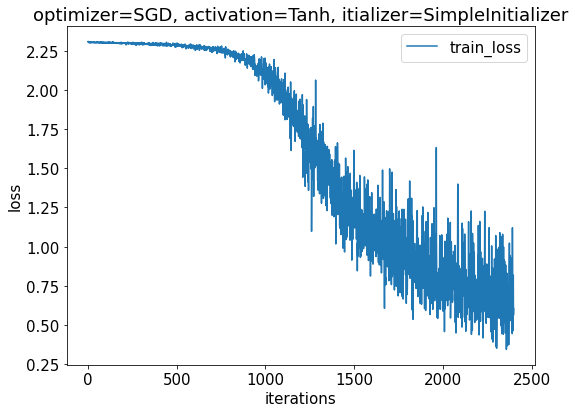

In [61]:
DNN3 = ScratchDeepNeuralNetrowkClassifier(batch_size, n_features, n_nodes1, n_nodes2, n_output, lr=0.01)

get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20, seed=10)

# 2400回分ミニバッチを実行する
for i in range(len(get_mini_batch)):

    mini_X_train, mini_y_train = get_mini_batch[i]

    DNN3.fit(mini_X_train, mini_y_train)

# 学習曲線をプロット
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(8,6))

plt.title('optimizer=SGD, activation=Tanh, itializer=SimpleInitializer')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(get_mini_batch)), DNN3.loss_list, label='train_loss')
# plt.plot(range(len(val_get_mini_batch)), NN.val_loss_list, label = 'val_loss')

plt.legend()
plt.tight_layout()
plt.show()

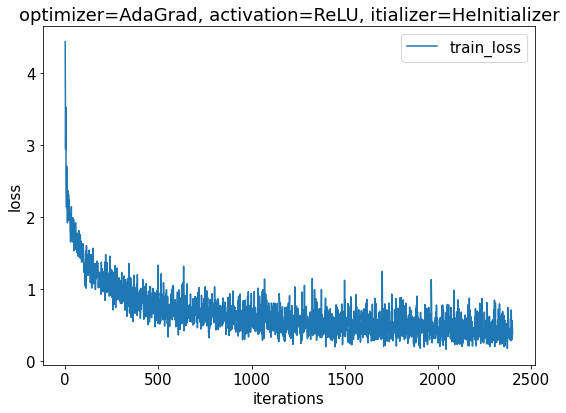

In [62]:
DNN4 = ScratchDeepNeuralNetrowkClassifier(batch_size, n_features, n_nodes1, n_nodes2, n_output, lr=0.01, optimizer=AdaGrad, activation=ReLU, itializer=HeInitializer)

get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20, seed=10)

# 2400回分ミニバッチを実行する
for i in range(len(get_mini_batch)):

    mini_X_train, mini_y_train = get_mini_batch[i]

    DNN4.fit(mini_X_train, mini_y_train)

# 学習曲線をプロット
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(8,6))

plt.title('optimizer=AdaGrad, activation=ReLU, itializer=HeInitializer')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(get_mini_batch)), DNN4.loss_list, label='train_loss')
# plt.plot(range(len(val_get_mini_batch)), NN.val_loss_list, label = 'val_loss')

plt.legend()
plt.tight_layout()
plt.show()